In this notebook, we assume that 5 instances of each of the 4 models have already been pre-trained on the Fontainebleau area. The weights of the pre-trained instances are loaded from the 'Sentinel_model_weigths' folder. Alternatively, the training can be reproduced using the 'Sentinel_training' notebook.

# Imports

In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import random as rd
import copy as cp
from time import time
import math

# import torch
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR, CosineAnnealingLR, ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import autograd
import torch.cuda
from torch.func import stack_module_state, vmap, functional_call
import gc

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

try :
  print(torch.cuda.get_device_name(0))
except :
  print("No GPU is available.")

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def mse_loss(x, x_hat):
    """
    Calculate the Mean Squared Error (MSE) loss between input and reconstructed data.

    Args:
        x (torch.Tensor): Input data.
        x_hat (torch.Tensor): Reconstructed data.

    Returns:
        torch.Tensor: Mean squared error loss.
    """
    total_prediction_loss = torch.sum((x-x_hat)**2)/(x.size()[0])
    return total_prediction_loss

cuda:0
NVIDIA A100-SXM4-40GB


In [2]:
!git clone https://github.com/anthony-frion/AIKAE

Cloning into 'AIKAE'...
remote: Enumerating objects: 92, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 92 (delta 24), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (92/92), 12.36 MiB | 15.60 MiB/s, done.
Resolving deltas: 100% (24/24), done.


In [3]:
from AIKAE.models import KoopmanAE, IKAE, IKAE_zp, AIKAE, NICE, RealNVP

In [4]:
def rescale(im, minim=None, maxim=None):
    if maxim is None :
      maxim = np.amax(im)
    if minim is None :
      minim = np.amin(im)
    return (im-minim)/(maxim-minim)

In [5]:
def truncate(im):
  im[im < 0] = 0
  im[im > 1] = 1
  return im

In [6]:
def mse_loss(x, x_hat):
  total_prediction_loss = torch.sum((x-x_hat)**2)/(x.size()[0])
  return total_prediction_loss

# Import data with gdown

Running the cell below enables you to download the Sentinel-2 data directly from Google Drive. Another option is to download the files from https://drive.google.com/drive/u/1/folders/1doHnjryCMptkzxYFfw-ILwAD0tOK3LGH and then use them at will, either locally or on a Google Colab session.

In [7]:
# Fontainebleau interpolated time series
!gdown 1ZWH06EQYTiBUHRABVH2o_s2I_9Zm6dpo -O Fontainebleau_interpolated.npy

# Orléans irregular time series and its mask
!gdown 1K2QtxcJjnzCpPgBQnXrTyAM_yoyi2710 -O Orléans_irregular.npy
!gdown 17IjvRhWT4dzyr9vlKQOjoolYAzTvLfvF -O Orléans_mask.npy

Downloading...
From (original): https://drive.google.com/uc?id=1ZWH06EQYTiBUHRABVH2o_s2I_9Zm6dpo
From (redirected): https://drive.google.com/uc?id=1ZWH06EQYTiBUHRABVH2o_s2I_9Zm6dpo&confirm=t&uuid=54fb8b16-d6ac-463f-87c4-3708a01bc07c
To: /content/Fontainebleau_interpolated.npy
100% 3.43G/3.43G [00:30<00:00, 111MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1K2QtxcJjnzCpPgBQnXrTyAM_yoyi2710
From (redirected): https://drive.google.com/uc?id=1K2QtxcJjnzCpPgBQnXrTyAM_yoyi2710&confirm=t&uuid=0173b8fa-4a73-4979-9718-1f368c401de4
To: /content/Orléans_irregular.npy
100% 3.43G/3.43G [00:24<00:00, 141MB/s]
Downloading...
From: https://drive.google.com/uc?id=17IjvRhWT4dzyr9vlKQOjoolYAzTvLfvF
To: /content/Orléans_mask.npy
100% 2.87k/2.87k [00:00<00:00, 13.5MB/s]


In [8]:
data = np.load('Fontainebleau_interpolated.npy')
max_Fontainebleau = np.max(data)

In [9]:
# We rescale the data to values between 0 and 1
if np.max(data) > 1:
  data /= max_Fontainebleau
  data *= 3 # Arbitrary rescaling and thresholding since the max is highly saturated
  data[data > 1] = 1

In [10]:
print(data.shape)
#343 -> temporal index ; 10 -> spectral band index ; 500, 500 -> spatial indexes

(343, 10, 500, 500)


In [11]:
data_test = np.load('Orléans_irregular.npy')
mask_test = np.load('Orléans_mask.npy')

In [12]:
# We rescale the data to values between 0 and 1
if np.max(data_test) > 3:
  data_test /= max_Fontainebleau
  data_test *= 3 # Arbitrary rescaling since the max is highly saturated
  # This time we do not impose a threshold of 1

In [13]:
# We extract 150x150 squares out of the 500x500 pixel time series

data_small = data[:,:,250:350,250:350].transpose(0,2,3,1) #150x150
reflectances = data_small.transpose(3,1,2,0)

data_test_small = data_test[:,:,150:250,150:250].transpose(0,2,3,1) #150x150
reflectances_test = data_test_small.transpose(3,1,2,0)

# Testing

## Assimilation-forecasting Fontainebleau

### KAE

In [14]:
model = KoopmanAE.KoopmanAE(20, [512,256,32], device=device).to(device)

In [15]:
# Constrained forecasting, with no Tikhonov spatial prior

size = 100 # Limit for 40GB of GPU memory, reduce the number if you do not have enough
time_span = 241
reflectances = data_small.transpose(3,1,2,0)
initial_state_total = torch.Tensor(reflectances[:,:size,:size,1]).to(device)
initial_state_total = torch.cat((initial_state_total, torch.Tensor(reflectances[:,:size,:size,1] - reflectances[:,:size,:size,0]).cuda())).permute((1,2,0))
reflectances_cuda = torch.Tensor(reflectances[:,:size,:size]).to(device)

trained_models_path = 'AIKAE/Sentinel_model_weights/KAE/'
nb_seeds = 5
steps = 4
MSE_list = np.zeros(nb_seeds)
MAE_list = np.zeros(nb_seeds)
final_losses = []
for seed in range(nb_seeds):
  final_losses.append(0)
  print(f"Seed number {seed}")
  model.load_state_dict(torch.load(trained_models_path+f'best_model_{seed}.pt'))
  model.K = torch.load(trained_models_path+f'best_K_{seed}.pt')
  predictions = torch.zeros((reflectances_cuda.shape[0]*2,
                             reflectances_cuda.shape[1],
                             reflectances_cuda.shape[2],
                             reflectances_cuda.shape[3]-1))#.to(device)for step in range(steps):
  for k in range(steps):
    print(f"Columns {k*(size//steps)} to {(k+1)*(size//steps)}")
    initial_latent_state = model.encode(initial_state_total[k*(size//steps):(k+1)*(size//steps)].flatten(0,1)).reshape((size//steps, size, model.latent_dim))
    initial_latent_state = torch.clone(initial_latent_state).detach()
    initial_latent_state = initial_latent_state.requires_grad_()

    epochs = 201
    #epochs = 101
    opt = torch.optim.Adam([initial_latent_state], lr=1e-3)
    for epoch in range(epochs) :
      opt.zero_grad()
      phis = [initial_latent_state.flatten(0,1)]
      for t in range(time_span) :
        phis.append(model.one_step_ahead(phis[-1]))
      phis = torch.cat(tuple(phi.unsqueeze(0) for phi in phis))
      decoded = model.decode(phis.flatten(0,1)).reshape((time_span+1, size//steps, size, 20)).permute((3,1,2,0))
      loss = mse_loss(decoded[:10], reflectances_cuda[:,k*(size//steps):(k+1)*(size//steps),:,1:time_span+2])
      loss.backward()
      opt.step()
      if epoch % 10 == 0 :
        print(f"Epoch {epoch} : loss {loss.item()}")
    final_losses[-1] += loss.item()
    phis = [initial_latent_state.flatten(0,1)]
    for t in range(predictions.shape[-1]-1) :
      phis.append(model.one_step_ahead(phis[-1]))
    phis = torch.cat(tuple(phi.unsqueeze(0) for phi in phis))
    decoded = model.decode(phis.flatten(0,1)).reshape((predictions.shape[-1], size//steps, size, 20)).permute((3,1,2,0))
    predictions[:,k*(size//steps):(k+1)*(size//steps),:,:] = decoded.cpu().detach()

  MSE = torch.mean((predictions[:10].cpu().detach() - reflectances_cuda.cpu().detach()[:,:,:,1:])[:,:,:,time_span+2:] **2)
  print(f"Final test MSE : {MSE}")
  MSE_list[seed] = MSE
  MAE = torch.mean(torch.abs(predictions[:10].cpu().detach() - reflectances_cuda.cpu().detach()[:,:,:,1:])[:,:,:,time_span+2:])
  print(f"Final test MAE : {MAE}")
  MAE_list[seed] = MAE
print(f"Mean and standard deviation of extrapolation MSE over {nb_seeds} seeds: {np.mean(MSE_list)} +- {np.std(MSE_list)}")
print(f"Mean and standard deviation of extrapolation MAE over {nb_seeds} seeds: {np.mean(MAE_list)} +- {np.std(MAE_list)}")
print(f"MSE: {np.mean(MSE_list)}, MAE: {np.mean(MAE_list)}")

Seed number 0
Columns 0 to 25


<ipython-input-15-0b9b94790c09>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(trained_models_path+f'best_model_{seed}.pt'))
<ipython-inp

Epoch 0 : loss 504.4412536621094
Epoch 10 : loss 132.2000274658203
Epoch 20 : loss 93.77278900146484
Epoch 30 : loss 77.44866943359375
Epoch 40 : loss 69.71651458740234
Epoch 50 : loss 65.76280212402344
Epoch 60 : loss 63.5949821472168
Epoch 70 : loss 62.29397201538086
Epoch 80 : loss 61.4676628112793
Epoch 90 : loss 60.9027099609375
Epoch 100 : loss 60.49453353881836
Epoch 110 : loss 60.182796478271484
Epoch 120 : loss 59.94145584106445
Epoch 130 : loss 59.741981506347656
Epoch 140 : loss 59.58673858642578
Epoch 150 : loss 59.46704864501953
Epoch 160 : loss 59.370391845703125
Epoch 170 : loss 59.285579681396484
Epoch 180 : loss 59.21455001831055
Epoch 190 : loss 59.15726852416992
Epoch 200 : loss 59.11164474487305
Columns 25 to 50
Epoch 0 : loss 576.7379150390625
Epoch 10 : loss 130.00613403320312
Epoch 20 : loss 90.1787338256836
Epoch 30 : loss 73.10050964355469
Epoch 40 : loss 64.55007934570312
Epoch 50 : loss 60.18610763549805
Epoch 60 : loss 57.78573226928711
Epoch 70 : loss 56.36

Expected result -> MSE: 0.0011231523938477039, MAE: 0.021348286792635916

### IKAE

In [16]:
model = IKAE.IKAE(input_dim=20, hidden_dim=256, n_layers_encoder=6, positive_nonlin=nn.Softplus(), flow='NICE', device=device).to(device)

In [17]:
# Constrained forecasting, with no Tikhonov spatial prior

size = 100 # Limit for 40GB of GPU memory, reduce the number if you do not have enough
time_span = 241
reflectances = data_small.transpose(3,1,2,0)
initial_state_total = torch.Tensor(reflectances[:,:size,:size,1]).to(device)
initial_state_total = torch.cat((initial_state_total, torch.Tensor(reflectances[:,:size,:size,1] - reflectances[:,:size,:size,0]).cuda())).permute((1,2,0))
reflectances_cuda = torch.Tensor(reflectances[:,:size,:size]).to(device)

trained_models_path = 'AIKAE/Sentinel_model_weights/IKAE/'
nb_seeds = 5
steps = 4
MSE_list = np.zeros(nb_seeds)
MAE_list = np.zeros(nb_seeds)
final_losses = []
for seed in range(nb_seeds):
  final_losses.append(0)
  print(f"Seed number {seed}")
  model.load_state_dict(torch.load(trained_models_path+f'best_model_{seed}.pt'))
  model.K = torch.load(trained_models_path+f'best_K_{seed}.pt')
  predictions = torch.zeros((reflectances_cuda.shape[0]*2,
                             reflectances_cuda.shape[1],
                             reflectances_cuda.shape[2],
                             reflectances_cuda.shape[3]-1))#.to(device)for step in range(steps):
  for k in range(steps):
    print(f"Columns {k*(size//steps)} to {(k+1)*(size//steps)}")
    initial_latent_state = model.encode(initial_state_total[k*(size//steps):(k+1)*(size//steps)].flatten(0,1)).reshape((size//steps, size, model.latent_dim))
    initial_latent_state = torch.clone(initial_latent_state).detach()
    initial_latent_state = initial_latent_state.requires_grad_()

    epochs = 201
    #epochs = 101
    opt = torch.optim.Adam([initial_latent_state], lr=1e-3)
    for epoch in range(epochs) :
      opt.zero_grad()
      phis = [initial_latent_state.flatten(0,1)]
      for t in range(time_span) :
        phis.append(model.one_step_ahead(phis[-1]))
      phis = torch.cat(tuple(phi.unsqueeze(0) for phi in phis))
      decoded = model.decode(phis.flatten(0,1)).reshape((time_span+1, size//steps, size, 20)).permute((3,1,2,0))
      loss = mse_loss(decoded[:10], reflectances_cuda[:,k*(size//steps):(k+1)*(size//steps),:,1:time_span+2])
      loss.backward()
      opt.step()
      if epoch % 10 == 0 :
        print(f"Epoch {epoch} : loss {loss.item()}")
    final_losses[-1] += loss.item()
    phis = [initial_latent_state.flatten(0,1)]
    for t in range(predictions.shape[-1]-1) :
      phis.append(model.one_step_ahead(phis[-1]))
    phis = torch.cat(tuple(phi.unsqueeze(0) for phi in phis))
    decoded = model.decode(phis.flatten(0,1)).reshape((predictions.shape[-1], size//steps, size, 20)).permute((3,1,2,0))
    predictions[:,k*(size//steps):(k+1)*(size//steps),:,:] = decoded.cpu().detach()

  MSE = torch.mean((predictions[:10].cpu().detach() - reflectances_cuda.cpu().detach()[:,:,:,1:])[:,:,:,time_span+2:] **2)
  print(f"Final test MSE : {MSE}")
  MSE_list[seed] = MSE
  MAE = torch.mean(torch.abs(predictions[:10].cpu().detach() - reflectances_cuda.cpu().detach()[:,:,:,1:])[:,:,:,time_span+2:])
  print(f"Final test MAE : {MAE}")
  MAE_list[seed] = MAE
print(f"Mean and standard deviation of extrapolation MSE over {nb_seeds} seeds: {np.mean(MSE_list)} +- {np.std(MSE_list)}")
print(f"Mean and standard deviation of extrapolation MAE over {nb_seeds} seeds: {np.mean(MAE_list)} +- {np.std(MAE_list)}")
print(f"MSE: {np.mean(MSE_list)}, MAE: {np.mean(MAE_list)}")

Seed number 0
Columns 0 to 25
Epoch 0 : loss 613.7294311523438


<ipython-input-17-392ff7e394d5>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(trained_models_path+f'best_model_{seed}.pt'))
<ipython-inp

Epoch 10 : loss 221.73757934570312
Epoch 20 : loss 183.1663055419922
Epoch 30 : loss 167.0647430419922
Epoch 40 : loss 159.48904418945312
Epoch 50 : loss 155.6735076904297
Epoch 60 : loss 153.4056396484375
Epoch 70 : loss 151.92176818847656
Epoch 80 : loss 150.8636474609375
Epoch 90 : loss 150.06199645996094
Epoch 100 : loss 149.42579650878906
Epoch 110 : loss 148.9108428955078
Epoch 120 : loss 148.4781951904297
Epoch 130 : loss 148.11148071289062
Epoch 140 : loss 147.8000946044922
Epoch 150 : loss 147.53453063964844
Epoch 160 : loss 147.3074188232422
Epoch 170 : loss 147.10955810546875
Epoch 180 : loss 146.94081115722656
Epoch 190 : loss 146.79322814941406
Epoch 200 : loss 146.6609649658203
Columns 25 to 50
Epoch 0 : loss 892.50537109375
Epoch 10 : loss 234.6584014892578
Epoch 20 : loss 182.0171661376953
Epoch 30 : loss 158.90159606933594
Epoch 40 : loss 148.08067321777344
Epoch 50 : loss 142.7282257080078
Epoch 60 : loss 139.38235473632812
Epoch 70 : loss 137.2580108642578
Epoch 80 :

**Expected result** -> MSE: 0.0012798122595995664, MAE: 0.022436308860778808

### IKAE with zero padding

In [18]:
model = IKAE_zp.IKAE_zp(input_dim=20, hidden_dim=256, n_layers_encoder=6, zero_padding=16, positive_nonlin=nn.Softplus(), flow='NICE', device=device).to(device)

In [19]:
# Constrained forecasting, with no Tikhonov spatial prior

size = 100 # Limit for 40GB of GPU memory, reduce the number if you do not have enough
time_span = 241
reflectances = data_small.transpose(3,1,2,0)
initial_state_total = torch.Tensor(reflectances[:,:size,:size,1]).to(device)
initial_state_total = torch.cat((initial_state_total, torch.Tensor(reflectances[:,:size,:size,1] - reflectances[:,:size,:size,0]).cuda())).permute((1,2,0))
reflectances_cuda = torch.Tensor(reflectances[:,:size,:size]).to(device)

trained_models_path = 'AIKAE/Sentinel_model_weights/IKAE_zp/'
nb_seeds = 5
steps = 4
MSE_list = np.zeros(nb_seeds)
MAE_list = np.zeros(nb_seeds)
final_losses = []
for seed in range(nb_seeds):
  final_losses.append(0)
  print(f"Seed number {seed}")
  model.load_state_dict(torch.load(trained_models_path+f'best_model_{seed}.pt'))
  model.K = torch.load(trained_models_path+f'best_K_{seed}.pt')
  predictions = torch.zeros((reflectances_cuda.shape[0]*2,
                             reflectances_cuda.shape[1],
                             reflectances_cuda.shape[2],
                             reflectances_cuda.shape[3]-1))#.to(device)for step in range(steps):
  for k in range(steps):
    print(f"Columns {k*(size//steps)} to {(k+1)*(size//steps)}")
    initial_latent_state = model.encode(initial_state_total[k*(size//steps):(k+1)*(size//steps)].flatten(0,1)).reshape((size//steps, size, model.latent_dim))
    initial_latent_state = torch.clone(initial_latent_state).detach()
    initial_latent_state = initial_latent_state.requires_grad_()

    epochs = 201
    #epochs = 101
    opt = torch.optim.Adam([initial_latent_state], lr=1e-3)
    for epoch in range(epochs) :
      opt.zero_grad()
      phis = [initial_latent_state.flatten(0,1)]
      for t in range(time_span) :
        phis.append(model.one_step_ahead(phis[-1]))
      phis = torch.cat(tuple(phi.unsqueeze(0) for phi in phis))
      decoded = model.decode(phis.flatten(0,1)).reshape((time_span+1, size//steps, size, 20)).permute((3,1,2,0))
      loss = mse_loss(decoded[:10], reflectances_cuda[:,k*(size//steps):(k+1)*(size//steps),:,1:time_span+2])
      loss.backward()
      opt.step()
      if epoch % 10 == 0 :
        print(f"Epoch {epoch} : loss {loss.item()}")
    final_losses[-1] += loss.item()
    phis = [initial_latent_state.flatten(0,1)]
    for t in range(predictions.shape[-1]-1) :
      phis.append(model.one_step_ahead(phis[-1]))
    phis = torch.cat(tuple(phi.unsqueeze(0) for phi in phis))
    decoded = model.decode(phis.flatten(0,1)).reshape((predictions.shape[-1], size//steps, size, 20)).permute((3,1,2,0))
    predictions[:,k*(size//steps):(k+1)*(size//steps),:,:] = decoded.cpu().detach()

  MSE = torch.mean((predictions[:10].cpu().detach() - reflectances_cuda.cpu().detach()[:,:,:,1:])[:,:,:,time_span+2:] **2)
  print(f"Final test MSE : {MSE}")
  MSE_list[seed] = MSE
  MAE = torch.mean(torch.abs(predictions[:10].cpu().detach() - reflectances_cuda.cpu().detach()[:,:,:,1:])[:,:,:,time_span+2:])
  print(f"Final test MAE : {MAE}")
  MAE_list[seed] = MAE
print(f"Mean and standard deviation of extrapolation MSE over {nb_seeds} seeds: {np.mean(MSE_list)} +- {np.std(MSE_list)}")
print(f"Mean and standard deviation of extrapolation MAE over {nb_seeds} seeds: {np.mean(MAE_list)} +- {np.std(MAE_list)}")
print(f"MSE: {np.mean(MSE_list)}, MAE: {np.mean(MAE_list)}")

Seed number 0
Columns 0 to 25
Epoch 0 : loss 509.6618347167969


<ipython-input-19-1af86d984753>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(trained_models_path+f'best_model_{seed}.pt'))
<ipython-inp

Epoch 10 : loss 145.359130859375
Epoch 20 : loss 113.42559051513672
Epoch 30 : loss 99.60214233398438
Epoch 40 : loss 92.71370697021484
Epoch 50 : loss 88.95684051513672
Epoch 60 : loss 86.67536926269531
Epoch 70 : loss 85.17726135253906
Epoch 80 : loss 84.1003189086914
Epoch 90 : loss 83.29695892333984
Epoch 100 : loss 82.67057037353516
Epoch 110 : loss 82.1699447631836
Epoch 120 : loss 81.76033782958984
Epoch 130 : loss 81.41815185546875
Epoch 140 : loss 81.12738037109375
Epoch 150 : loss 80.8765640258789
Epoch 160 : loss 80.65879821777344
Epoch 170 : loss 80.46713256835938
Epoch 180 : loss 80.2981185913086
Epoch 190 : loss 80.14886474609375
Epoch 200 : loss 80.01457977294922
Columns 25 to 50
Epoch 0 : loss 537.2721557617188
Epoch 10 : loss 133.9837188720703
Epoch 20 : loss 99.89533233642578
Epoch 30 : loss 85.17516326904297
Epoch 40 : loss 78.12181854248047
Epoch 50 : loss 74.2403335571289
Epoch 60 : loss 71.88221740722656
Epoch 70 : loss 70.3517074584961
Epoch 80 : loss 69.26488494

**Expected result** -> MSE: 0.0010587360942736269, MAE: 0.021236931532621385

### AIKAE

In [20]:
model = AIKAE.AIKAE(input_dim=20, hidden_dim=256, n_layers_encoder=6, augmentation_dims=[512,512,16], positive_nonlin=nn.Softplus(), flow='NICE', device=device).to(device)

In [21]:
# Constrained forecasting, with no Tikhonov spatial prior

size = 100 # Limit for 40GB of GPU memory, reduce the number if you do not have enough
time_span = 241
reflectances = data_small.transpose(3,1,2,0)
initial_state_total = torch.Tensor(reflectances[:,:size,:size,1]).to(device)
initial_state_total = torch.cat((initial_state_total, torch.Tensor(reflectances[:,:size,:size,1] - reflectances[:,:size,:size,0]).cuda())).permute((1,2,0))
reflectances_cuda = torch.Tensor(reflectances[:,:size,:size]).to(device)

trained_models_path = 'AIKAE/Sentinel_model_weights/AIKAE/'
nb_seeds = 5
steps = 4
MSE_list = np.zeros(nb_seeds)
MAE_list = np.zeros(nb_seeds)
final_losses = []
for seed in range(nb_seeds):
  final_losses.append(0)
  print(f"Seed number {seed}")
  model.load_state_dict(torch.load(trained_models_path+f'best_model_{seed}.pt'))
  model.K = torch.load(trained_models_path+f'best_K_{seed}.pt')
  predictions = torch.zeros((reflectances_cuda.shape[0]*2,
                             reflectances_cuda.shape[1],
                             reflectances_cuda.shape[2],
                             reflectances_cuda.shape[3]-1))#.to(device)for step in range(steps):
  for k in range(steps):
    print(f"Columns {k*(size//steps)} to {(k+1)*(size//steps)}")
    initial_latent_state = model.encode(initial_state_total[k*(size//steps):(k+1)*(size//steps)].flatten(0,1)).reshape((size//steps, size, model.latent_dim))
    initial_latent_state = torch.clone(initial_latent_state).detach()
    initial_latent_state = initial_latent_state.requires_grad_()

    epochs = 201
    #epochs = 101
    opt = torch.optim.Adam([initial_latent_state], lr=1e-3)
    for epoch in range(epochs) :
      opt.zero_grad()
      phis = [initial_latent_state.flatten(0,1)]
      for t in range(time_span) :
        phis.append(model.one_step_ahead(phis[-1]))
      phis = torch.cat(tuple(phi.unsqueeze(0) for phi in phis))
      decoded = model.decode(phis.flatten(0,1)).reshape((time_span+1, size//steps, size, 20)).permute((3,1,2,0))
      loss = mse_loss(decoded[:10], reflectances_cuda[:,k*(size//steps):(k+1)*(size//steps),:,1:time_span+2])
      loss.backward()
      opt.step()
      if epoch % 10 == 0 :
        print(f"Epoch {epoch} : loss {loss.item()}")
    final_losses[-1] += loss.item()
    phis = [initial_latent_state.flatten(0,1)]
    for t in range(predictions.shape[-1]-1) :
      phis.append(model.one_step_ahead(phis[-1]))
    phis = torch.cat(tuple(phi.unsqueeze(0) for phi in phis))
    decoded = model.decode(phis.flatten(0,1)).reshape((predictions.shape[-1], size//steps, size, 20)).permute((3,1,2,0))
    predictions[:,k*(size//steps):(k+1)*(size//steps),:,:] = decoded.cpu().detach()

  MSE = torch.mean((predictions[:10].cpu().detach() - reflectances_cuda.cpu().detach()[:,:,:,1:])[:,:,:,time_span+2:] **2)
  print(f"Final test MSE : {MSE}")
  MSE_list[seed] = MSE
  MAE = torch.mean(torch.abs(predictions[:10].cpu().detach() - reflectances_cuda.cpu().detach()[:,:,:,1:])[:,:,:,time_span+2:])
  print(f"Final test MAE : {MAE}")
  MAE_list[seed] = MAE
print(f"Mean and standard deviation of extrapolation MSE over {nb_seeds} seeds: {np.mean(MSE_list)} +- {np.std(MSE_list)}")
print(f"Mean and standard deviation of extrapolation MAE over {nb_seeds} seeds: {np.mean(MAE_list)} +- {np.std(MAE_list)}")
print(f"MSE: {np.mean(MSE_list)}, MAE: {np.mean(MAE_list)}")

Seed number 0
Columns 0 to 25
Epoch 0 : loss 642.1813354492188


<ipython-input-21-f44d4004899f>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(trained_models_path+f'best_model_{seed}.pt'))
<ipython-inp

Epoch 10 : loss 165.63084411621094
Epoch 20 : loss 128.72108459472656
Epoch 30 : loss 114.07286834716797
Epoch 40 : loss 107.05794525146484
Epoch 50 : loss 103.5483169555664
Epoch 60 : loss 101.59407043457031
Epoch 70 : loss 100.39631652832031
Epoch 80 : loss 99.60124969482422
Epoch 90 : loss 99.03216552734375
Epoch 100 : loss 98.6021957397461
Epoch 110 : loss 98.26335906982422
Epoch 120 : loss 97.99113464355469
Epoch 130 : loss 97.76751708984375
Epoch 140 : loss 97.58153533935547
Epoch 150 : loss 97.427001953125
Epoch 160 : loss 97.2960433959961
Epoch 170 : loss 97.1865005493164
Epoch 180 : loss 97.09354400634766
Epoch 190 : loss 97.01495361328125
Epoch 200 : loss 96.9475326538086
Columns 25 to 50
Epoch 0 : loss 832.3255004882812
Epoch 10 : loss 176.13670349121094
Epoch 20 : loss 134.80233764648438
Epoch 30 : loss 115.3023681640625
Epoch 40 : loss 105.58336639404297
Epoch 50 : loss 100.7983627319336
Epoch 60 : loss 98.28175354003906
Epoch 70 : loss 96.80950164794922
Epoch 80 : loss 95

**Expected result** -> MSE: 0.0010844699339941145, MAE: 0.020444613695144654

## Assimilation-forecasting Orléans

### KAE (optimal)

In [22]:
model = KoopmanAE.KoopmanAE(20, [512,256,32], device=device).to(device)

In [23]:
size = 100 # Limit for 40GB of GPU memory, reduce the number if you do not have enough
time_span = 241
reflectances_test = data_test_small.transpose(3,1,2,0)[:,:size,:size]
second_date = np.argmax(mask_test[1:])+1
initial_state_total = torch.Tensor((reflectances_test[:,:,:,0] * (second_date - 1) + reflectances_test[:,:,:,second_date])) / second_date
initial_state_total = initial_state_total.to(device)
derivative = torch.Tensor(reflectances_test[:,:,:,second_date] - reflectances_test[:,:,:,0]) / second_date
initial_state_total = torch.cat((initial_state_total, derivative.to(device))).permute((1,2,0))

reflectances_cuda = torch.Tensor(reflectances_test[:,:size,:size]).to(device)

trained_models_path = 'AIKAE/Sentinel_model_weights/KAE/'
nb_seeds = 5
steps = 4
MSE_list = np.zeros(nb_seeds)
MAE_list = np.zeros(nb_seeds)
final_losses = []
for seed in range(nb_seeds):
#for seed in[1]:
  print(f"Seed number {seed}")
  final_losses.append(0)
  model.load_state_dict(torch.load(trained_models_path+f'best_model_{seed}.pt'))
  model.K = torch.load(trained_models_path+f'best_K_{seed}.pt')
  predictions = torch.zeros((reflectances_cuda.shape[0]*2,
                             reflectances_cuda.shape[1],
                             reflectances_cuda.shape[2],
                             reflectances_cuda.shape[3]))
  for k in range(steps):
    print(f"Columns {k*(size//steps)} to {(k+1)*(size//steps)}")
    initial_latent_state = model.encode(initial_state_total[k*(size//steps):(k+1)*(size//steps)].flatten(0,1)).reshape((size//steps, size, model.latent_dim))
    initial_latent_state = torch.clone(initial_latent_state).detach()
    initial_latent_state = initial_latent_state.requires_grad_()

    # Optimal hyperparameters for the assimilation
    epochs = 101
    opt = torch.optim.Adam([initial_latent_state], lr=1e-3)

    losses = []
    for epoch in range(epochs) :
      opt.zero_grad()
      phis = [initial_latent_state.flatten(0,1)]
      for t in range(time_span) :
        phis.append(model.one_step_ahead(phis[-1]))
      phis = torch.cat(tuple(phi.unsqueeze(0) for phi in phis))
      decoded = model.decode(phis[mask_test[:time_span+1]==1].flatten(0,1)).reshape(np.sum(mask_test[:time_span+1]==1),size//steps,size,20).permute((3,1,2,0))
      loss = mse_loss(decoded[:10], reflectances_cuda[:,k*(size//steps):(k+1)*(size//steps),:,:time_span+1][:,:,:,mask_test[:time_span+1]==1])
      loss.backward()
      opt.step()
      if epoch % 10 == 0 :
        print(f"Epoch {epoch} : loss {loss.item()}")
    final_losses[-1] += loss.item()
    phis = [initial_latent_state.flatten(0,1)]
    for t in range(reflectances_cuda.shape[3]-1) :
      phis.append(model.one_step_ahead(phis[-1]))
    phis = torch.cat(tuple(phi.unsqueeze(0) for phi in phis))
    predictions[:,k*(size//steps):(k+1)*(size//steps)] = model.decode(phis.flatten(0,1)).reshape(reflectances_cuda.shape[3],size//steps,size,20).permute((3,1,2,0)).cpu().detach()
  print(predictions.shape, reflectances_cuda.shape)
  MSE = torch.mean((predictions[:10].cpu().detach() - reflectances_cuda.cpu().detach())[:,:,:,time_span+2:][:,:,:,mask_test[time_span+2:]==1] **2).item()
  MAE = torch.mean(torch.abs(predictions[:10].cpu().detach() - reflectances_cuda.cpu().detach())[:,:,:,time_span+2:][:,:,:,mask_test[time_span+2:]==1]).item()
  print(f"Final test MSE : {MSE}")
  MSE_list[seed] = MSE
  print(f"Final test MAE : {MAE}")
  MAE_list[seed] = MAE
print(f"Mean and standard deviation of extrapolation MSE over {nb_seeds} seeds: {np.mean(MSE_list)} +- {np.std(MSE_list)}")
print(f"Mean and standard deviation of extrapolation MAE over {nb_seeds} seeds: {np.mean(MAE_list)} +- {np.std(MAE_list)}")
print(f"MSE: {np.mean(MSE_list)}, MAE: {np.mean(MAE_list)}")

Seed number 0
Columns 0 to 25


<ipython-input-23-848df09816ff>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(trained_models_path+f'best_model_{seed}.pt'))
<ipython-inp

Epoch 0 : loss 1339.115478515625
Epoch 10 : loss 438.8092956542969
Epoch 20 : loss 356.3758544921875
Epoch 30 : loss 316.6241149902344
Epoch 40 : loss 294.51629638671875
Epoch 50 : loss 281.64599609375
Epoch 60 : loss 273.4485778808594
Epoch 70 : loss 267.8312072753906
Epoch 80 : loss 263.74908447265625
Epoch 90 : loss 260.6833801269531
Epoch 100 : loss 258.3053894042969
Columns 25 to 50
Epoch 0 : loss 1015.37109375
Epoch 10 : loss 339.6673889160156
Epoch 20 : loss 275.8825378417969
Epoch 30 : loss 243.98838806152344
Epoch 40 : loss 226.48643493652344
Epoch 50 : loss 216.10009765625
Epoch 60 : loss 209.31961059570312
Epoch 70 : loss 204.74571228027344
Epoch 80 : loss 201.4609832763672
Epoch 90 : loss 198.97059631347656
Epoch 100 : loss 197.05386352539062
Columns 50 to 75
Epoch 0 : loss 1415.4293212890625
Epoch 10 : loss 451.4190979003906
Epoch 20 : loss 350.3312683105469
Epoch 30 : loss 302.0936584472656
Epoch 40 : loss 275.9898376464844
Epoch 50 : loss 260.50244140625
Epoch 60 : loss 

**Expected result** -> MSE: 0.0034569785930216312, MAE: 0.038376621156930926

### KAE (overfit)

In [24]:
model = KoopmanAE.KoopmanAE(20, [512,256,32], device=device).to(device)

In [25]:
size = 100 # Limit for 40GB of GPU memory, reduce the number if you do not have enough
time_span = 241
reflectances_test = data_test_small.transpose(3,1,2,0)[:,:size,:size]
second_date = np.argmax(mask_test[1:])+1
initial_state_total = torch.Tensor((reflectances_test[:,:,:,0] * (second_date - 1) + reflectances_test[:,:,:,second_date])) / second_date
initial_state_total = initial_state_total.to(device)
derivative = torch.Tensor(reflectances_test[:,:,:,second_date] - reflectances_test[:,:,:,0]) / second_date
initial_state_total = torch.cat((initial_state_total, derivative.to(device))).permute((1,2,0))

reflectances_cuda = torch.Tensor(reflectances_test[:,:size,:size]).to(device)

trained_models_path = 'AIKAE/Sentinel_model_weights/KAE/'
nb_seeds = 5
steps = 4
MSE_list = np.zeros(nb_seeds)
MAE_list = np.zeros(nb_seeds)
final_losses = []
for seed in range(nb_seeds):
#for seed in[1]:
  print(f"Seed number {seed}")
  final_losses.append(0)
  model.load_state_dict(torch.load(trained_models_path+f'best_model_{seed}.pt'))
  model.K = torch.load(trained_models_path+f'best_K_{seed}.pt')
  predictions = torch.zeros((reflectances_cuda.shape[0]*2,
                             reflectances_cuda.shape[1],
                             reflectances_cuda.shape[2],
                             reflectances_cuda.shape[3]))
  for k in range(steps):
    print(f"Columns {k*(size//steps)} to {(k+1)*(size//steps)}")
    initial_latent_state = model.encode(initial_state_total[k*(size//steps):(k+1)*(size//steps)].flatten(0,1)).reshape((size//steps, size, model.latent_dim))
    initial_latent_state = torch.clone(initial_latent_state).detach()
    initial_latent_state = initial_latent_state.requires_grad_()

    # Subptimal hyperparameters for the assimilation, leading to overfitting of the assimilated data
    epochs = 201
    opt = torch.optim.Adam([initial_latent_state], lr=1e-2)

    losses = []
    for epoch in range(epochs) :
      opt.zero_grad()
      phis = [initial_latent_state.flatten(0,1)]
      for t in range(time_span) :
        phis.append(model.one_step_ahead(phis[-1]))
      phis = torch.cat(tuple(phi.unsqueeze(0) for phi in phis))
      decoded = model.decode(phis[mask_test[:time_span+1]==1].flatten(0,1)).reshape(np.sum(mask_test[:time_span+1]==1),size//steps,size,20).permute((3,1,2,0))
      loss = mse_loss(decoded[:10], reflectances_cuda[:,k*(size//steps):(k+1)*(size//steps),:,:time_span+1][:,:,:,mask_test[:time_span+1]==1])
      loss.backward()
      opt.step()
      if epoch % 10 == 0 :
        print(f"Epoch {epoch} : loss {loss.item()}")
    final_losses[-1] += loss.item()
    phis = [initial_latent_state.flatten(0,1)]
    for t in range(reflectances_cuda.shape[3]-1) :
      phis.append(model.one_step_ahead(phis[-1]))
    phis = torch.cat(tuple(phi.unsqueeze(0) for phi in phis))
    predictions[:,k*(size//steps):(k+1)*(size//steps)] = model.decode(phis.flatten(0,1)).reshape(reflectances_cuda.shape[3],size//steps,size,20).permute((3,1,2,0)).cpu().detach()
  print(predictions.shape, reflectances_cuda.shape)
  MSE = torch.mean((predictions[:10].cpu().detach() - reflectances_cuda.cpu().detach())[:,:,:,time_span+2:][:,:,:,mask_test[time_span+2:]==1] **2).item()
  MAE = torch.mean(torch.abs(predictions[:10].cpu().detach() - reflectances_cuda.cpu().detach())[:,:,:,time_span+2:][:,:,:,mask_test[time_span+2:]==1]).item()
  print(f"Final test MSE : {MSE}")
  MSE_list[seed] = MSE
  print(f"Final test MAE : {MAE}")
  MAE_list[seed] = MAE
print(f"Mean and standard deviation of extrapolation MSE over {nb_seeds} seeds: {np.mean(MSE_list)} +- {np.std(MSE_list)}")
print(f"Mean and standard deviation of extrapolation MAE over {nb_seeds} seeds: {np.mean(MAE_list)} +- {np.std(MAE_list)}")
print(f"MSE: {np.mean(MSE_list)}, MAE: {np.mean(MAE_list)}")

Seed number 0
Columns 0 to 25
Epoch 0 : loss 1339.115478515625


<ipython-input-25-3208d90cc004>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(trained_models_path+f'best_model_{seed}.pt'))
<ipython-inp

Epoch 10 : loss 692.6299438476562
Epoch 20 : loss 456.44488525390625
Epoch 30 : loss 351.08038330078125
Epoch 40 : loss 300.96063232421875
Epoch 50 : loss 275.3598327636719
Epoch 60 : loss 261.4675598144531
Epoch 70 : loss 253.94029235839844
Epoch 80 : loss 249.3876495361328
Epoch 90 : loss 246.74002075195312
Epoch 100 : loss 245.000244140625
Epoch 110 : loss 243.8551788330078
Epoch 120 : loss 243.1795196533203
Epoch 130 : loss 242.8549346923828
Epoch 140 : loss 242.29307556152344
Epoch 150 : loss 242.0935516357422
Epoch 160 : loss 241.8068389892578
Epoch 170 : loss 241.53746032714844
Epoch 180 : loss 241.41197204589844
Epoch 190 : loss 241.290771484375
Epoch 200 : loss 241.1469268798828
Columns 25 to 50
Epoch 0 : loss 1015.37109375
Epoch 10 : loss 633.0838623046875
Epoch 20 : loss 396.74261474609375
Epoch 30 : loss 294.0105895996094
Epoch 40 : loss 244.44775390625
Epoch 50 : loss 219.23733520507812
Epoch 60 : loss 206.1819305419922
Epoch 70 : loss 198.5651397705078
Epoch 80 : loss 194

**Expected result** -> MSE: 0.004025051603093743, MAE: 0.04185555875301361

### IKAE

In [26]:
model = IKAE.IKAE(input_dim=20, hidden_dim=256, n_layers_encoder=6, positive_nonlin=nn.Softplus(), flow='NICE', device=device).to(device)

In [27]:
size = 100 # Limit for 40GB of GPU memory, reduce the number if you do not have enough
time_span = 241
reflectances_test = data_test_small.transpose(3,1,2,0)[:,:size,:size]
second_date = np.argmax(mask_test[1:])+1
initial_state_total = torch.Tensor((reflectances_test[:,:,:,0] * (second_date - 1) + reflectances_test[:,:,:,second_date])) / second_date
initial_state_total = initial_state_total.to(device)
derivative = torch.Tensor(reflectances_test[:,:,:,second_date] - reflectances_test[:,:,:,0]) / second_date
initial_state_total = torch.cat((initial_state_total, derivative.to(device))).permute((1,2,0))

reflectances_cuda = torch.Tensor(reflectances_test[:,:size,:size]).to(device)

trained_models_path = 'AIKAE/Sentinel_model_weights/IKAE/'
nb_seeds = 5
steps = 4
MSE_list = np.zeros(nb_seeds)
MAE_list = np.zeros(nb_seeds)
final_losses = []
for seed in range(nb_seeds):
#for seed in[1]:
  print(f"Seed number {seed}")
  final_losses.append(0)
  model.load_state_dict(torch.load(trained_models_path+f'best_model_{seed}.pt'))
  model.K = torch.load(trained_models_path+f'best_K_{seed}.pt')
  predictions = torch.zeros((reflectances_cuda.shape[0]*2,
                             reflectances_cuda.shape[1],
                             reflectances_cuda.shape[2],
                             reflectances_cuda.shape[3]))
  for k in range(steps):
    print(f"Columns {k*(size//steps)} to {(k+1)*(size//steps)}")
    initial_latent_state = model.encode(initial_state_total[k*(size//steps):(k+1)*(size//steps)].flatten(0,1)).reshape((size//steps, size, model.latent_dim))
    initial_latent_state = torch.clone(initial_latent_state).detach()
    initial_latent_state = initial_latent_state.requires_grad_()

    # Subptimal hyperparameters for the assimilation, leading to overfitting of the assimilated data
    epochs = 201
    opt = torch.optim.Adam([initial_latent_state], lr=1e-2)

    losses = []
    for epoch in range(epochs) :
      opt.zero_grad()
      phis = [initial_latent_state.flatten(0,1)]
      for t in range(time_span) :
        phis.append(model.one_step_ahead(phis[-1]))
      phis = torch.cat(tuple(phi.unsqueeze(0) for phi in phis))
      decoded = model.decode(phis[mask_test[:time_span+1]==1].flatten(0,1)).reshape(np.sum(mask_test[:time_span+1]==1),size//steps,size,20).permute((3,1,2,0))
      loss = mse_loss(decoded[:10], reflectances_cuda[:,k*(size//steps):(k+1)*(size//steps),:,:time_span+1][:,:,:,mask_test[:time_span+1]==1])
      loss.backward()
      opt.step()
      if epoch % 10 == 0 :
        print(f"Epoch {epoch} : loss {loss.item()}")
    final_losses[-1] += loss.item()
    phis = [initial_latent_state.flatten(0,1)]
    for t in range(reflectances_cuda.shape[3]-1) :
      phis.append(model.one_step_ahead(phis[-1]))
    phis = torch.cat(tuple(phi.unsqueeze(0) for phi in phis))
    predictions[:,k*(size//steps):(k+1)*(size//steps)] = model.decode(phis.flatten(0,1)).reshape(reflectances_cuda.shape[3],size//steps,size,20).permute((3,1,2,0)).cpu().detach()
  print(predictions.shape, reflectances_cuda.shape)
  MSE = torch.mean((predictions[:10].cpu().detach() - reflectances_cuda.cpu().detach())[:,:,:,time_span+2:][:,:,:,mask_test[time_span+2:]==1] **2).item()
  MAE = torch.mean(torch.abs(predictions[:10].cpu().detach() - reflectances_cuda.cpu().detach())[:,:,:,time_span+2:][:,:,:,mask_test[time_span+2:]==1]).item()
  print(f"Final test MSE : {MSE}")
  MSE_list[seed] = MSE
  print(f"Final test MAE : {MAE}")
  MAE_list[seed] = MAE
print(f"Mean and standard deviation of extrapolation MSE over {nb_seeds} seeds: {np.mean(MSE_list)} +- {np.std(MSE_list)}")
print(f"Mean and standard deviation of extrapolation MAE over {nb_seeds} seeds: {np.mean(MAE_list)} +- {np.std(MAE_list)}")
print(f"MSE: {np.mean(MSE_list)}, MAE: {np.mean(MAE_list)}")

Seed number 0
Columns 0 to 25
Epoch 0 : loss 1529.3148193359375


<ipython-input-27-a0f451706eeb>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(trained_models_path+f'best_model_{seed}.pt'))
<ipython-inp

Epoch 10 : loss 577.9630737304688
Epoch 20 : loss 464.4493103027344
Epoch 30 : loss 422.179443359375
Epoch 40 : loss 401.7126770019531
Epoch 50 : loss 390.900634765625
Epoch 60 : loss 384.872802734375
Epoch 70 : loss 381.2257995605469
Epoch 80 : loss 378.93841552734375
Epoch 90 : loss 377.4203796386719
Epoch 100 : loss 376.3406982421875
Epoch 110 : loss 375.5633544921875
Epoch 120 : loss 375.01165771484375
Epoch 130 : loss 374.5977478027344
Epoch 140 : loss 374.291259765625
Epoch 150 : loss 374.0319519042969
Epoch 160 : loss 373.8285827636719
Epoch 170 : loss 373.67822265625
Epoch 180 : loss 373.5611877441406
Epoch 190 : loss 373.43243408203125
Epoch 200 : loss 373.3769226074219
Columns 25 to 50
Epoch 0 : loss 1219.4891357421875
Epoch 10 : loss 458.0116882324219
Epoch 20 : loss 369.7397155761719
Epoch 30 : loss 331.3427734375
Epoch 40 : loss 313.8207702636719
Epoch 50 : loss 304.1778564453125
Epoch 60 : loss 298.80389404296875
Epoch 70 : loss 295.7080078125
Epoch 80 : loss 293.73214721

**Expected result** -> MSE: 0.0038200434297323226, MAE: 0.039897150546312335

### IKAE with zero padding

In [28]:
model = IKAE_zp.IKAE_zp(input_dim=20, hidden_dim=256, n_layers_encoder=6, zero_padding=16, positive_nonlin=nn.Softplus(), flow='NICE', device=device).to(device)

In [29]:
size = 100 # Limit for 40GB of GPU memory, reduce the number if you do not have enough
time_span = 241
reflectances_test = data_test_small.transpose(3,1,2,0)[:,:size,:size]
second_date = np.argmax(mask_test[1:])+1
initial_state_total = torch.Tensor((reflectances_test[:,:,:,0] * (second_date - 1) + reflectances_test[:,:,:,second_date])) / second_date
initial_state_total = initial_state_total.to(device)
derivative = torch.Tensor(reflectances_test[:,:,:,second_date] - reflectances_test[:,:,:,0]) / second_date
initial_state_total = torch.cat((initial_state_total, derivative.to(device))).permute((1,2,0))

reflectances_cuda = torch.Tensor(reflectances_test[:,:size,:size]).to(device)

trained_models_path = 'AIKAE/Sentinel_model_weights/IKAE_zp/'
nb_seeds = 5
steps = 4
MSE_list = np.zeros(nb_seeds)
MAE_list = np.zeros(nb_seeds)
final_losses = []
for seed in range(nb_seeds):
#for seed in[1]:
  print(f"Seed number {seed}")
  final_losses.append(0)
  model.load_state_dict(torch.load(trained_models_path+f'best_model_{seed}.pt'))
  model.K = torch.load(trained_models_path+f'best_K_{seed}.pt')
  predictions = torch.zeros((reflectances_cuda.shape[0]*2,
                             reflectances_cuda.shape[1],
                             reflectances_cuda.shape[2],
                             reflectances_cuda.shape[3]))
  for k in range(steps):
    print(f"Columns {k*(size//steps)} to {(k+1)*(size//steps)}")
    initial_latent_state = model.encode(initial_state_total[k*(size//steps):(k+1)*(size//steps)].flatten(0,1)).reshape((size//steps, size, model.latent_dim))
    initial_latent_state = torch.clone(initial_latent_state).detach()
    initial_latent_state = initial_latent_state.requires_grad_()

    # Subptimal hyperparameters for the assimilation, leading to overfitting of the assimilated data
    epochs = 201
    opt = torch.optim.Adam([initial_latent_state], lr=1e-2)

    losses = []
    for epoch in range(epochs) :
      opt.zero_grad()
      phis = [initial_latent_state.flatten(0,1)]
      for t in range(time_span) :
        phis.append(model.one_step_ahead(phis[-1]))
      phis = torch.cat(tuple(phi.unsqueeze(0) for phi in phis))
      decoded = model.decode(phis[mask_test[:time_span+1]==1].flatten(0,1)).reshape(np.sum(mask_test[:time_span+1]==1),size//steps,size,20).permute((3,1,2,0))
      loss = mse_loss(decoded[:10], reflectances_cuda[:,k*(size//steps):(k+1)*(size//steps),:,:time_span+1][:,:,:,mask_test[:time_span+1]==1])
      loss.backward()
      opt.step()
      if epoch % 10 == 0 :
        print(f"Epoch {epoch} : loss {loss.item()}")
    final_losses[-1] += loss.item()
    phis = [initial_latent_state.flatten(0,1)]
    for t in range(reflectances_cuda.shape[3]-1) :
      phis.append(model.one_step_ahead(phis[-1]))
    phis = torch.cat(tuple(phi.unsqueeze(0) for phi in phis))
    predictions[:,k*(size//steps):(k+1)*(size//steps)] = model.decode(phis.flatten(0,1)).reshape(reflectances_cuda.shape[3],size//steps,size,20).permute((3,1,2,0)).cpu().detach()
  print(predictions.shape, reflectances_cuda.shape)
  MSE = torch.mean((predictions[:10].cpu().detach() - reflectances_cuda.cpu().detach())[:,:,:,time_span+2:][:,:,:,mask_test[time_span+2:]==1] **2).item()
  MAE = torch.mean(torch.abs(predictions[:10].cpu().detach() - reflectances_cuda.cpu().detach())[:,:,:,time_span+2:][:,:,:,mask_test[time_span+2:]==1]).item()
  print(f"Final test MSE : {MSE}")
  MSE_list[seed] = MSE
  print(f"Final test MAE : {MAE}")
  MAE_list[seed] = MAE
print(f"Mean and standard deviation of extrapolation MSE over {nb_seeds} seeds: {np.mean(MSE_list)} +- {np.std(MSE_list)}")
print(f"Mean and standard deviation of extrapolation MAE over {nb_seeds} seeds: {np.mean(MAE_list)} +- {np.std(MAE_list)}")
print(f"MSE: {np.mean(MSE_list)}, MAE: {np.mean(MAE_list)}")

Seed number 0
Columns 0 to 25
Epoch 0 : loss 1473.73828125


<ipython-input-29-c415ce572807>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(trained_models_path+f'best_model_{seed}.pt'))
<ipython-inp

Epoch 10 : loss 536.4387817382812
Epoch 20 : loss 400.7111511230469
Epoch 30 : loss 348.16082763671875
Epoch 40 : loss 322.7613220214844
Epoch 50 : loss 309.2631530761719
Epoch 60 : loss 301.7711181640625
Epoch 70 : loss 297.2448425292969
Epoch 80 : loss 294.4853820800781
Epoch 90 : loss 292.751220703125
Epoch 100 : loss 291.57171630859375
Epoch 110 : loss 290.8187561035156
Epoch 120 : loss 290.2016296386719
Epoch 130 : loss 289.7128601074219
Epoch 140 : loss 289.5241394042969
Epoch 150 : loss 289.15087890625
Epoch 160 : loss 288.9491271972656
Epoch 170 : loss 288.7695007324219
Epoch 180 : loss 288.5417175292969
Epoch 190 : loss 288.40435791015625
Epoch 200 : loss 288.370361328125
Columns 25 to 50
Epoch 0 : loss 1178.30712890625
Epoch 10 : loss 454.22119140625
Epoch 20 : loss 318.4308776855469
Epoch 30 : loss 268.68853759765625
Epoch 40 : loss 244.675537109375
Epoch 50 : loss 232.18130493164062
Epoch 60 : loss 225.2193145751953
Epoch 70 : loss 221.1793975830078
Epoch 80 : loss 218.7973

**Expected result** -> MSE: 0.0032924169674515722, MAE: 0.03794279098510742

### AIKAE

In [30]:
model = AIKAE.AIKAE(input_dim=20, hidden_dim=256, n_layers_encoder=6, augmentation_dims=[512,512,16], positive_nonlin=nn.Softplus(), flow='NICE', device=device).to(device)

In [31]:
size = 100 # Limit for 40GB of GPU memory, reduce the number if you do not have enough
time_span = 241
reflectances_test = data_test_small.transpose(3,1,2,0)[:,:size,:size]
second_date = np.argmax(mask_test[1:])+1
initial_state_total = torch.Tensor((reflectances_test[:,:,:,0] * (second_date - 1) + reflectances_test[:,:,:,second_date])) / second_date
initial_state_total = initial_state_total.to(device)
derivative = torch.Tensor(reflectances_test[:,:,:,second_date] - reflectances_test[:,:,:,0]) / second_date
initial_state_total = torch.cat((initial_state_total, derivative.to(device))).permute((1,2,0))

reflectances_cuda = torch.Tensor(reflectances_test[:,:size,:size]).to(device)

trained_models_path = 'AIKAE/Sentinel_model_weights/AIKAE/'
nb_seeds = 5
steps = 4
MSE_list = np.zeros(nb_seeds)
MAE_list = np.zeros(nb_seeds)
final_losses = []
for seed in range(nb_seeds):
#for seed in[1]:
  print(f"Seed number {seed}")
  final_losses.append(0)
  model.load_state_dict(torch.load(trained_models_path+f'best_model_{seed}.pt'))
  model.K = torch.load(trained_models_path+f'best_K_{seed}.pt')
  predictions = torch.zeros((reflectances_cuda.shape[0]*2,
                             reflectances_cuda.shape[1],
                             reflectances_cuda.shape[2],
                             reflectances_cuda.shape[3]))
  for k in range(steps):
    print(f"Columns {k*(size//steps)} to {(k+1)*(size//steps)}")
    initial_latent_state = model.encode(initial_state_total[k*(size//steps):(k+1)*(size//steps)].flatten(0,1)).reshape((size//steps, size, model.latent_dim))
    initial_latent_state = torch.clone(initial_latent_state).detach()
    initial_latent_state = initial_latent_state.requires_grad_()

    # Subptimal hyperparameters for the assimilation, leading to overfitting of the assimilated data
    epochs = 201
    opt = torch.optim.Adam([initial_latent_state], lr=1e-2)

    losses = []
    for epoch in range(epochs) :
      opt.zero_grad()
      phis = [initial_latent_state.flatten(0,1)]
      for t in range(time_span) :
        phis.append(model.one_step_ahead(phis[-1]))
      phis = torch.cat(tuple(phi.unsqueeze(0) for phi in phis))
      decoded = model.decode(phis[mask_test[:time_span+1]==1].flatten(0,1)).reshape(np.sum(mask_test[:time_span+1]==1),size//steps,size,20).permute((3,1,2,0))
      loss = mse_loss(decoded[:10], reflectances_cuda[:,k*(size//steps):(k+1)*(size//steps),:,:time_span+1][:,:,:,mask_test[:time_span+1]==1])
      loss.backward()
      opt.step()
      if epoch % 10 == 0 :
        print(f"Epoch {epoch} : loss {loss.item()}")
    final_losses[-1] += loss.item()
    phis = [initial_latent_state.flatten(0,1)]
    for t in range(reflectances_cuda.shape[3]-1) :
      phis.append(model.one_step_ahead(phis[-1]))
    phis = torch.cat(tuple(phi.unsqueeze(0) for phi in phis))
    predictions[:,k*(size//steps):(k+1)*(size//steps)] = model.decode(phis.flatten(0,1)).reshape(reflectances_cuda.shape[3],size//steps,size,20).permute((3,1,2,0)).cpu().detach()
  print(predictions.shape, reflectances_cuda.shape)
  MSE = torch.mean((predictions[:10].cpu().detach() - reflectances_cuda.cpu().detach())[:,:,:,time_span+2:][:,:,:,mask_test[time_span+2:]==1] **2).item()
  MAE = torch.mean(torch.abs(predictions[:10].cpu().detach() - reflectances_cuda.cpu().detach())[:,:,:,time_span+2:][:,:,:,mask_test[time_span+2:]==1]).item()
  print(f"Final test MSE : {MSE}")
  MSE_list[seed] = MSE
  print(f"Final test MAE : {MAE}")
  MAE_list[seed] = MAE
print(f"Mean and standard deviation of extrapolation MSE over {nb_seeds} seeds: {np.mean(MSE_list)} +- {np.std(MSE_list)}")
print(f"Mean and standard deviation of extrapolation MAE over {nb_seeds} seeds: {np.mean(MAE_list)} +- {np.std(MAE_list)}")
print(f"MSE: {np.mean(MSE_list)}, MAE: {np.mean(MAE_list)}")

Seed number 0
Columns 0 to 25
Epoch 0 : loss 1451.5771484375


<ipython-input-31-7c1c438b5be2>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(trained_models_path+f'best_model_{seed}.pt'))
<ipython-inp

Epoch 10 : loss 515.9172973632812
Epoch 20 : loss 376.8835144042969
Epoch 30 : loss 328.9254455566406
Epoch 40 : loss 305.69830322265625
Epoch 50 : loss 293.7631530761719
Epoch 60 : loss 287.3429870605469
Epoch 70 : loss 283.6999206542969
Epoch 80 : loss 281.5055847167969
Epoch 90 : loss 280.1037902832031
Epoch 100 : loss 279.1687927246094
Epoch 110 : loss 278.5229797363281
Epoch 120 : loss 278.0931701660156
Epoch 130 : loss 277.74334716796875
Epoch 140 : loss 277.4718322753906
Epoch 150 : loss 277.2763366699219
Epoch 160 : loss 277.11370849609375
Epoch 170 : loss 276.96881103515625
Epoch 180 : loss 276.8875427246094
Epoch 190 : loss 276.8177795410156
Epoch 200 : loss 276.70343017578125
Columns 25 to 50
Epoch 0 : loss 1106.5526123046875
Epoch 10 : loss 401.87371826171875
Epoch 20 : loss 284.72088623046875
Epoch 30 : loss 242.8915252685547
Epoch 40 : loss 223.4668426513672
Epoch 50 : loss 213.6056671142578
Epoch 60 : loss 208.3658447265625
Epoch 70 : loss 205.47305297851562
Epoch 80 : l

**Expected result** -> MSE: 0.0029677940998226403, MAE: 0.035593848675489426

# Visualise results

Here, we consider the best instance of each model (i.e. the one that gets the best forecasting MSE on the Orléans area). We first store the assimilation results of these instances, and then plot the assimilated trajectories for random pixels.

This section notably enables to reproduce a figure from the pre-print.

In [32]:
# Load Orléans data
size = 100 # Limit for 40GB of GPU memory, reduce the number if you do not have enough
time_span = 241
reflectances_test = data_test_small.transpose(3,1,2,0)[:,:size,:size]
second_date = np.argmax(mask_test[1:])+1
initial_state_total = torch.Tensor((reflectances_test[:,:,:,0] * (second_date - 1) + reflectances_test[:,:,:,second_date])) / second_date
initial_state_total = initial_state_total.to(device)
derivative = torch.Tensor(reflectances_test[:,:,:,second_date] - reflectances_test[:,:,:,0]) / second_date
initial_state_total = torch.cat((initial_state_total, derivative.to(device))).permute((1,2,0))

reflectances_cuda = torch.Tensor(reflectances_test[:,:size,:size]).to(device)

In [33]:
# KAE model
model = KoopmanAE.KoopmanAE(20, [512,256,32], device=device).to(device)
trained_models_path = 'AIKAE/Sentinel_model_weights/KAE/'
seed = 2 # Seed that obtains the best MSE
model.load_state_dict(torch.load(trained_models_path+f'best_model_{seed}.pt'))
model.K = torch.load(trained_models_path+f'best_K_{seed}.pt')

predictions_KAE = torch.zeros((reflectances_cuda.shape[0]*2,
                               reflectances_cuda.shape[1],
                               reflectances_cuda.shape[2],
                               reflectances_cuda.shape[3]))
steps = 4
for k in range(steps):
  print(f"Columns {k*(size//steps)} to {(k+1)*(size//steps)}")
  initial_latent_state = model.encode(initial_state_total[k*(size//steps):(k+1)*(size//steps)].flatten(0,1)).reshape((size//steps, size, model.latent_dim))
  initial_latent_state = torch.clone(initial_latent_state).detach()
  initial_latent_state = initial_latent_state.requires_grad_()

  # Optimal hyperparameters for the assimilation
  epochs = 101
  opt = torch.optim.Adam([initial_latent_state], lr=1e-3)

  losses = []
  for epoch in range(epochs) :
    opt.zero_grad()
    phis = [initial_latent_state.flatten(0,1)]
    for t in range(time_span) :
      phis.append(model.one_step_ahead(phis[-1]))
    phis = torch.cat(tuple(phi.unsqueeze(0) for phi in phis))
    decoded = model.decode(phis[mask_test[:time_span+1]==1].flatten(0,1)).reshape(np.sum(mask_test[:time_span+1]==1),size//steps,size,20).permute((3,1,2,0))
    loss = mse_loss(decoded[:10], reflectances_cuda[:,k*(size//steps):(k+1)*(size//steps),:,:time_span+1][:,:,:,mask_test[:time_span+1]==1])
    loss.backward()
    opt.step()
    if epoch % 20 == 0 :
      print(f"Epoch {epoch} : loss {loss.item()}")
  phis = [initial_latent_state.flatten(0,1)]
  for t in range(reflectances_cuda.shape[3]-1) :
    phis.append(model.one_step_ahead(phis[-1]))
  phis = torch.cat(tuple(phi.unsqueeze(0) for phi in phis))
  predictions_KAE[:,k*(size//steps):(k+1)*(size//steps)] = model.decode(phis.flatten(0,1)).reshape(reflectances_cuda.shape[3],size//steps,size,20).permute((3,1,2,0)).cpu().detach()
MSE = torch.mean((predictions_KAE[:10].cpu().detach() - reflectances_cuda.cpu().detach())[:,:,:,time_span+2:][:,:,:,mask_test[time_span+2:]==1] **2).item()
MAE = torch.mean(torch.abs(predictions_KAE[:10].cpu().detach() - reflectances_cuda.cpu().detach())[:,:,:,time_span+2:][:,:,:,mask_test[time_span+2:]==1]).item()
print(f"MSE: {MSE}, MAE: {MAE}")

Columns 0 to 25


<ipython-input-33-30588698e4a8>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(trained_models_path+f'best_model_{seed}.pt'))
<ipython-inpu

Epoch 0 : loss 1382.4383544921875
Epoch 20 : loss 367.02056884765625
Epoch 40 : loss 299.6361999511719
Epoch 60 : loss 277.3257751464844
Epoch 80 : loss 266.50958251953125
Epoch 100 : loss 260.2359313964844
Columns 25 to 50
Epoch 0 : loss 1070.175537109375
Epoch 20 : loss 279.83209228515625
Epoch 40 : loss 227.75010681152344
Epoch 60 : loss 211.19590759277344
Epoch 80 : loss 203.6571502685547
Epoch 100 : loss 199.412841796875
Columns 50 to 75
Epoch 0 : loss 1483.236328125
Epoch 20 : loss 378.1508483886719
Epoch 40 : loss 294.56390380859375
Epoch 60 : loss 266.2372741699219
Epoch 80 : loss 252.97439575195312
Epoch 100 : loss 245.4270477294922
Columns 75 to 100
Epoch 0 : loss 1256.336181640625
Epoch 20 : loss 308.8334045410156
Epoch 40 : loss 244.34263610839844
Epoch 60 : loss 221.63919067382812
Epoch 80 : loss 211.1411895751953
Epoch 100 : loss 205.33067321777344
MSE: 0.00322395795956254, MAE: 0.035588935017585754


In [34]:
# IKAE model
model = IKAE.IKAE(input_dim=20, hidden_dim=256, n_layers_encoder=6, positive_nonlin=nn.Softplus(), flow='NICE', device=device).to(device)
trained_models_path = 'AIKAE/Sentinel_model_weights/IKAE/'
seed = 4 # Seed that obtains the best MSE
model.load_state_dict(torch.load(trained_models_path+f'best_model_{seed}.pt'))
model.K = torch.load(trained_models_path+f'best_K_{seed}.pt')

predictions_IKAE = torch.zeros((reflectances_cuda.shape[0]*2,
                               reflectances_cuda.shape[1],
                               reflectances_cuda.shape[2],
                               reflectances_cuda.shape[3]))
steps = 4
for k in range(steps):
  print(f"Columns {k*(size//steps)} to {(k+1)*(size//steps)}")
  initial_latent_state = model.encode(initial_state_total[k*(size//steps):(k+1)*(size//steps)].flatten(0,1)).reshape((size//steps, size, model.latent_dim))
  initial_latent_state = torch.clone(initial_latent_state).detach()
  initial_latent_state = initial_latent_state.requires_grad_()

  # Optimal hyperparameters for the assimilation
  epochs = 201
  opt = torch.optim.Adam([initial_latent_state], lr=1e-2)

  losses = []
  for epoch in range(epochs) :
    opt.zero_grad()
    phis = [initial_latent_state.flatten(0,1)]
    for t in range(time_span) :
      phis.append(model.one_step_ahead(phis[-1]))
    phis = torch.cat(tuple(phi.unsqueeze(0) for phi in phis))
    decoded = model.decode(phis[mask_test[:time_span+1]==1].flatten(0,1)).reshape(np.sum(mask_test[:time_span+1]==1),size//steps,size,20).permute((3,1,2,0))
    loss = mse_loss(decoded[:10], reflectances_cuda[:,k*(size//steps):(k+1)*(size//steps),:,:time_span+1][:,:,:,mask_test[:time_span+1]==1])
    loss.backward()
    opt.step()
    if epoch % 20 == 0 :
      print(f"Epoch {epoch} : loss {loss.item()}")
  phis = [initial_latent_state.flatten(0,1)]
  for t in range(reflectances_cuda.shape[3]-1) :
    phis.append(model.one_step_ahead(phis[-1]))
  phis = torch.cat(tuple(phi.unsqueeze(0) for phi in phis))
  predictions_IKAE[:,k*(size//steps):(k+1)*(size//steps)] = model.decode(phis.flatten(0,1)).reshape(reflectances_cuda.shape[3],size//steps,size,20).permute((3,1,2,0)).cpu().detach()
MSE = torch.mean((predictions_IKAE[:10] - reflectances_cuda.cpu().detach())[:,:,:,time_span+2:][:,:,:,mask_test[time_span+2:]==1] **2).item()
MAE = torch.mean(torch.abs(predictions_IKAE[:10] - reflectances_cuda.cpu().detach())[:,:,:,time_span+2:][:,:,:,mask_test[time_span+2:]==1]).item()
print(f"MSE: {MSE}, MAE: {MAE}")

Columns 0 to 25
Epoch 0 : loss 1467.1737060546875


<ipython-input-34-15eba27d316c>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(trained_models_path+f'best_model_{seed}.pt'))
<ipython-inpu

Epoch 20 : loss 477.6307678222656
Epoch 40 : loss 397.8014221191406
Epoch 60 : loss 378.264892578125
Epoch 80 : loss 371.567626953125
Epoch 100 : loss 368.8451843261719
Epoch 120 : loss 367.6548767089844
Epoch 140 : loss 367.0666198730469
Epoch 160 : loss 366.7065124511719
Epoch 180 : loss 366.4878845214844
Epoch 200 : loss 366.3627624511719
Columns 25 to 50
Epoch 0 : loss 1109.3575439453125
Epoch 20 : loss 382.7518615722656
Epoch 40 : loss 310.3028869628906
Epoch 60 : loss 293.7680969238281
Epoch 80 : loss 288.5660705566406
Epoch 100 : loss 286.69573974609375
Epoch 120 : loss 285.8298645019531
Epoch 140 : loss 285.4129943847656
Epoch 160 : loss 285.19757080078125
Epoch 180 : loss 285.0353088378906
Epoch 200 : loss 284.94677734375
Columns 50 to 75
Epoch 0 : loss 1497.379150390625
Epoch 20 : loss 478.96783447265625
Epoch 40 : loss 394.1018981933594
Epoch 60 : loss 373.9186096191406
Epoch 80 : loss 367.2376403808594
Epoch 100 : loss 364.61627197265625
Epoch 120 : loss 363.3340759277344
E

In [35]:
# IKAE with zero padding model
model = IKAE_zp.IKAE_zp(input_dim=20, hidden_dim=256, n_layers_encoder=6, zero_padding=16, positive_nonlin=nn.Softplus(), flow='NICE', device=device).to(device)
trained_models_path = 'AIKAE/Sentinel_model_weights/IKAE_zp/'
seed = 1 # Seed that obtains the best MSE
model.load_state_dict(torch.load(trained_models_path+f'best_model_{seed}.pt'))
model.K = torch.load(trained_models_path+f'best_K_{seed}.pt')

predictions_IKAE_zp = torch.zeros((reflectances_cuda.shape[0]*2,
                               reflectances_cuda.shape[1],
                               reflectances_cuda.shape[2],
                               reflectances_cuda.shape[3]))
steps = 4
for k in range(steps):
  print(f"Columns {k*(size//steps)} to {(k+1)*(size//steps)}")
  initial_latent_state = model.encode(initial_state_total[k*(size//steps):(k+1)*(size//steps)].flatten(0,1)).reshape((size//steps, size, model.latent_dim))
  initial_latent_state = torch.clone(initial_latent_state).detach()
  initial_latent_state = initial_latent_state.requires_grad_()

  # Optimal hyperparameters for the assimilation
  epochs = 201
  opt = torch.optim.Adam([initial_latent_state], lr=1e-2)

  losses = []
  for epoch in range(epochs) :
    opt.zero_grad()
    phis = [initial_latent_state.flatten(0,1)]
    for t in range(time_span) :
      phis.append(model.one_step_ahead(phis[-1]))
    phis = torch.cat(tuple(phi.unsqueeze(0) for phi in phis))
    decoded = model.decode(phis[mask_test[:time_span+1]==1].flatten(0,1)).reshape(np.sum(mask_test[:time_span+1]==1),size//steps,size,20).permute((3,1,2,0))
    loss = mse_loss(decoded[:10], reflectances_cuda[:,k*(size//steps):(k+1)*(size//steps),:,:time_span+1][:,:,:,mask_test[:time_span+1]==1])
    loss.backward()
    opt.step()
    if epoch % 20 == 0 :
      print(f"Epoch {epoch} : loss {loss.item()}")
  phis = [initial_latent_state.flatten(0,1)]
  for t in range(reflectances_cuda.shape[3]-1) :
    phis.append(model.one_step_ahead(phis[-1]))
  phis = torch.cat(tuple(phi.unsqueeze(0) for phi in phis))
  predictions_IKAE_zp[:,k*(size//steps):(k+1)*(size//steps)] = model.decode(phis.flatten(0,1)).reshape(reflectances_cuda.shape[3],size//steps,size,20).permute((3,1,2,0)).cpu().detach()
MSE = torch.mean((predictions_IKAE_zp[:10].cpu().detach() - reflectances_cuda.cpu().detach())[:,:,:,time_span+2:][:,:,:,mask_test[time_span+2:]==1] **2).item()
MAE = torch.mean(torch.abs(predictions_IKAE_zp[:10].cpu().detach() - reflectances_cuda.cpu().detach())[:,:,:,time_span+2:][:,:,:,mask_test[time_span+2:]==1]).item()
print(f"MSE: {MSE}, MAE: {MAE}")

Columns 0 to 25
Epoch 0 : loss 1453.730712890625


<ipython-input-35-5ff9280fae6d>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(trained_models_path+f'best_model_{seed}.pt'))
<ipython-inpu

Epoch 20 : loss 416.7652282714844
Epoch 40 : loss 328.2017517089844
Epoch 60 : loss 305.453369140625
Epoch 80 : loss 297.90802001953125
Epoch 100 : loss 294.7376403808594
Epoch 120 : loss 293.1253967285156
Epoch 140 : loss 292.1903991699219
Epoch 160 : loss 291.5314025878906
Epoch 180 : loss 291.0624694824219
Epoch 200 : loss 290.6905212402344
Columns 25 to 50
Epoch 0 : loss 1149.9354248046875
Epoch 20 : loss 341.5096740722656
Epoch 40 : loss 250.9468994140625
Epoch 60 : loss 227.43603515625
Epoch 80 : loss 219.68399047851562
Epoch 100 : loss 216.50279235839844
Epoch 120 : loss 214.97634887695312
Epoch 140 : loss 214.01695251464844
Epoch 160 : loss 213.5369415283203
Epoch 180 : loss 213.083251953125
Epoch 200 : loss 212.9681396484375
Columns 50 to 75
Epoch 0 : loss 1460.5599365234375
Epoch 20 : loss 399.0413513183594
Epoch 40 : loss 298.18975830078125
Epoch 60 : loss 272.18798828125
Epoch 80 : loss 263.6284484863281
Epoch 100 : loss 260.0951843261719
Epoch 120 : loss 258.23443603515625

In [36]:
# AIKAE model
model = AIKAE.AIKAE(input_dim=20, hidden_dim=256, n_layers_encoder=6, augmentation_dims=[512,512,16], positive_nonlin=nn.Softplus(), flow='NICE', device=device).to(device)
trained_models_path = 'AIKAE/Sentinel_model_weights/AIKAE/'
seed = 0 # Seed that obtains the best MSE
model.load_state_dict(torch.load(trained_models_path+f'best_model_{seed}.pt'))
model.K = torch.load(trained_models_path+f'best_K_{seed}.pt')

predictions_AIKAE = torch.zeros((reflectances_cuda.shape[0]*2,
                               reflectances_cuda.shape[1],
                               reflectances_cuda.shape[2],
                               reflectances_cuda.shape[3]))
steps = 4
for k in range(steps):
  print(f"Columns {k*(size//steps)} to {(k+1)*(size//steps)}")
  initial_latent_state = model.encode(initial_state_total[k*(size//steps):(k+1)*(size//steps)].flatten(0,1)).reshape((size//steps, size, model.latent_dim))
  initial_latent_state = torch.clone(initial_latent_state).detach()
  initial_latent_state = initial_latent_state.requires_grad_()

  # Optimal hyperparameters for the assimilation
  epochs = 201
  opt = torch.optim.Adam([initial_latent_state], lr=1e-2)

  losses = []
  for epoch in range(epochs) :
    opt.zero_grad()
    phis = [initial_latent_state.flatten(0,1)]
    for t in range(time_span) :
      phis.append(model.one_step_ahead(phis[-1]))
    phis = torch.cat(tuple(phi.unsqueeze(0) for phi in phis))
    decoded = model.decode(phis[mask_test[:time_span+1]==1].flatten(0,1)).reshape(np.sum(mask_test[:time_span+1]==1),size//steps,size,20).permute((3,1,2,0))
    loss = mse_loss(decoded[:10], reflectances_cuda[:,k*(size//steps):(k+1)*(size//steps),:,:time_span+1][:,:,:,mask_test[:time_span+1]==1])
    loss.backward()
    opt.step()
    if epoch % 20 == 0 :
      print(f"Epoch {epoch} : loss {loss.item()}")
  phis = [initial_latent_state.flatten(0,1)]
  for t in range(reflectances_cuda.shape[3]-1) :
    phis.append(model.one_step_ahead(phis[-1]))
  phis = torch.cat(tuple(phi.unsqueeze(0) for phi in phis))
  predictions_AIKAE[:,k*(size//steps):(k+1)*(size//steps)] = model.decode(phis.flatten(0,1)).reshape(reflectances_cuda.shape[3],size//steps,size,20).permute((3,1,2,0)).cpu().detach()
MSE = torch.mean((predictions_AIKAE[:10].cpu().detach() - reflectances_cuda.cpu().detach())[:,:,:,time_span+2:][:,:,:,mask_test[time_span+2:]==1] **2).item()
MAE = torch.mean(torch.abs(predictions_AIKAE[:10].cpu().detach() - reflectances_cuda.cpu().detach())[:,:,:,time_span+2:][:,:,:,mask_test[time_span+2:]==1]).item()
print(f"MSE: {MSE}, MAE: {MAE}")

Columns 0 to 25
Epoch 0 : loss 1451.5771484375


<ipython-input-36-9fe9611454ed>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(trained_models_path+f'best_model_{seed}.pt'))
<ipython-inpu

Epoch 20 : loss 376.8835144042969
Epoch 40 : loss 305.69830322265625
Epoch 60 : loss 287.3429870605469
Epoch 80 : loss 281.5055847167969
Epoch 100 : loss 279.1687927246094
Epoch 120 : loss 278.0931701660156
Epoch 140 : loss 277.4718322753906
Epoch 160 : loss 277.11370849609375
Epoch 180 : loss 276.8875427246094
Epoch 200 : loss 276.70343017578125
Columns 25 to 50
Epoch 0 : loss 1106.5526123046875
Epoch 20 : loss 284.72088623046875
Epoch 40 : loss 223.4668426513672
Epoch 60 : loss 208.3658447265625
Epoch 80 : loss 203.73397827148438
Epoch 100 : loss 201.94216918945312
Epoch 120 : loss 201.12496948242188
Epoch 140 : loss 200.71157836914062
Epoch 160 : loss 200.43148803710938
Epoch 180 : loss 200.3075408935547
Epoch 200 : loss 200.2071990966797
Columns 50 to 75
Epoch 0 : loss 1576.5712890625
Epoch 20 : loss 368.1147155761719
Epoch 40 : loss 286.1427001953125
Epoch 60 : loss 265.94586181640625
Epoch 80 : loss 259.4524841308594
Epoch 100 : loss 256.829833984375
Epoch 120 : loss 255.64721679

(18, 90)


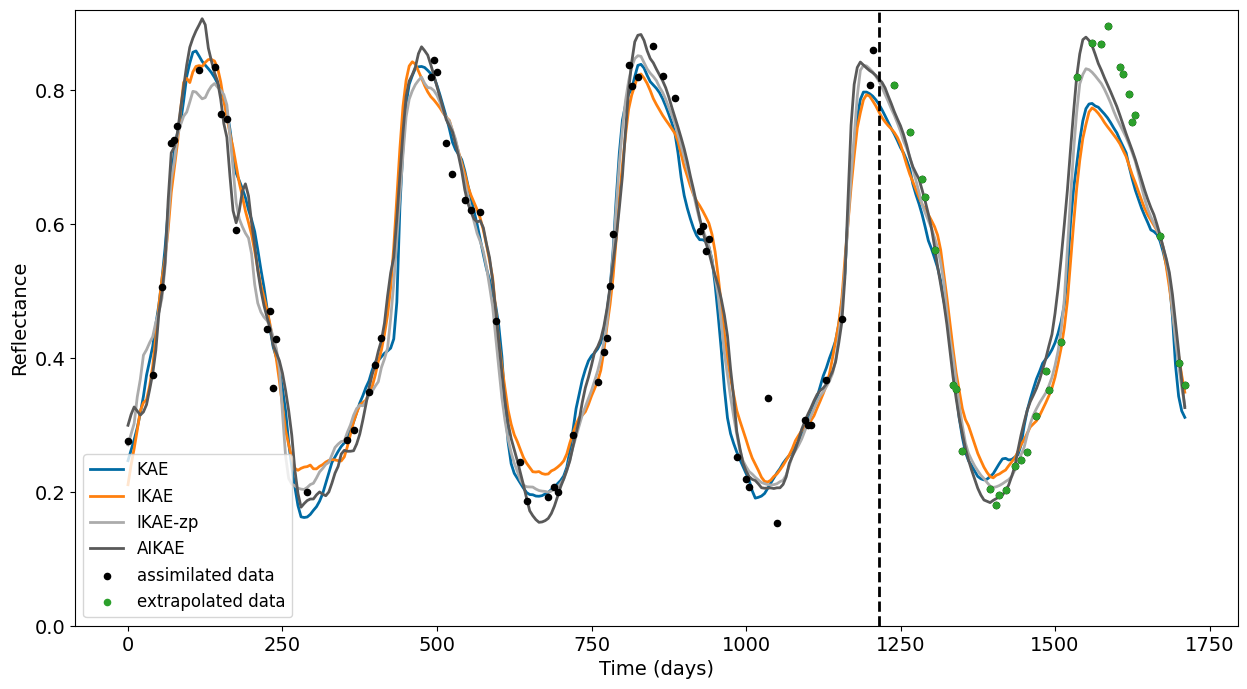

In [37]:
# This cell reproduces figure 3 from the pre-print
test_pixel = (18,90) # Gives the figure from the pre-print
X = np.array([5*k for k in range(reflectances.shape[3])])
print(test_pixel)
band = 6

plt.style.use('tableau-colorblind10')
plt.figure(figsize=(15,8))
plt.ylim(0, 0.92)
plt.xlabel('Time (days)', size=14)
plt.ylabel('Reflectance', size=14)

plt.plot(X, predictions_KAE[band,test_pixel[0],test_pixel[1]].cpu().detach(), linewidth=2, label='KAE')
plt.plot(X, predictions_IKAE[band,test_pixel[0],test_pixel[1]].cpu().detach(), linewidth=2, label='IKAE') # Uncomment to the the IKAE result
plt.plot(X, predictions_IKAE_zp[band,test_pixel[0],test_pixel[1]].cpu().detach(), linewidth=2, label='IKAE-zp')
plt.plot(X, predictions_AIKAE[band,test_pixel[0],test_pixel[1]].cpu().detach(), linewidth=2, label='AIKAE')
plt.scatter(X[mask_test==1], reflectances_test[band,test_pixel[0],test_pixel[1],:][mask_test==1], s=20, c='black', label='assimilated data', zorder=4)
plt.scatter(X[-100:][mask_test[-100:]==1], reflectances_test[band,test_pixel[0],test_pixel[1],-100:][mask_test[-100:]==1], s=20, c='tab:green', label='extrapolated data', zorder=4)
plt.axvline(X[-100], 0, 1, c='black', linestyle='dashed', linewidth=2)

plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(fontsize=12, loc='lower left')

plt.savefig('Assimilation-forecasting.pdf', bbox_inches='tight')

Visualisation for spectral band 9 on pixel (69, 70)


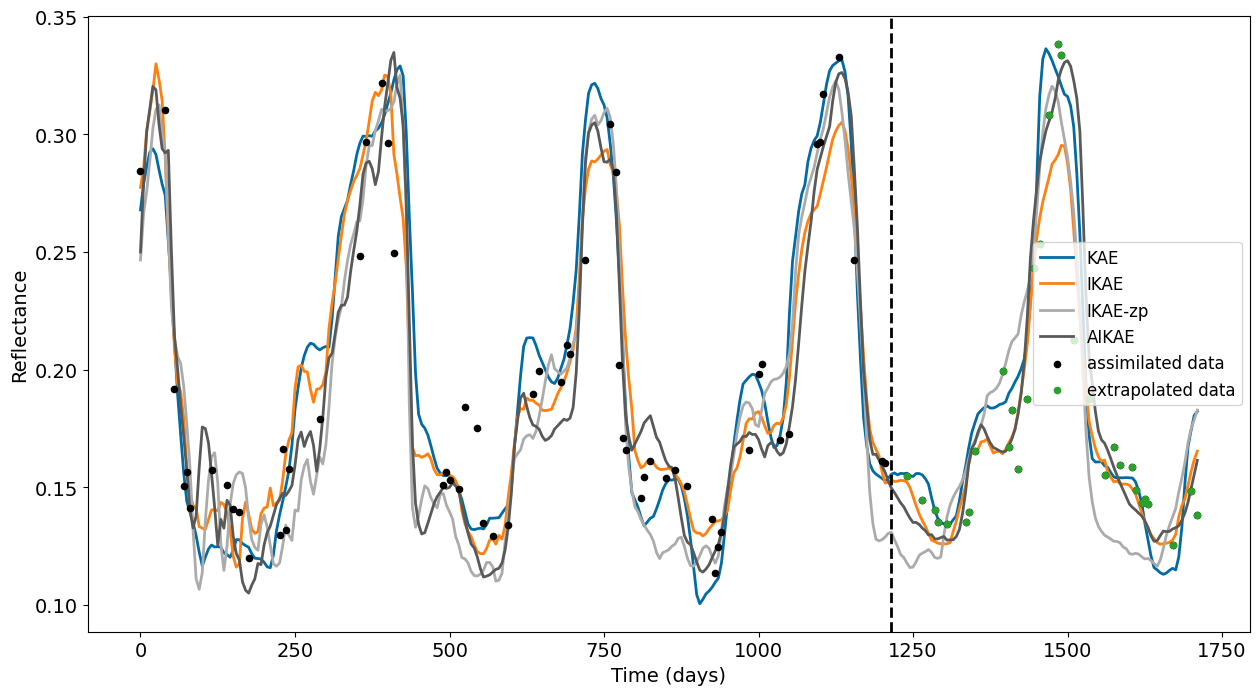

In [45]:
# This cell shows a similar visualisation
test_pixel = (rd.randint(0,size-1), rd.randint(0, size-1)) # Uncomment to show the results for another pixel
X = np.array([5*k for k in range(reflectances.shape[3])])
band = rd.randint(0, 9)
print(f"Visualisation for spectral band {band} on pixel {test_pixel}")

plt.style.use('tableau-colorblind10')
plt.figure(figsize=(15,8))
plt.xlabel('Time (days)', size=14)
plt.ylabel('Reflectance', size=14)

plt.plot(X, predictions_KAE[band,test_pixel[0],test_pixel[1]].cpu().detach(), linewidth=2, label='KAE')
plt.plot(X, predictions_IKAE[band,test_pixel[0],test_pixel[1]].cpu().detach(), linewidth=2, label='IKAE') # Uncomment to the the IKAE result
plt.plot(X, predictions_IKAE_zp[band,test_pixel[0],test_pixel[1]].cpu().detach(), linewidth=2, label='IKAE-zp')
plt.plot(X, predictions_AIKAE[band,test_pixel[0],test_pixel[1]].cpu().detach(), linewidth=2, label='AIKAE')
plt.scatter(X[mask_test==1], reflectances_test[band,test_pixel[0],test_pixel[1],:][mask_test==1], s=20, c='black', label='assimilated data', zorder=4)
plt.scatter(X[-100:][mask_test[-100:]==1], reflectances_test[band,test_pixel[0],test_pixel[1],-100:][mask_test[-100:]==1], s=20, c='tab:green', label='extrapolated data', zorder=4)
plt.axvline(X[-100], 0, 1, c='black', linestyle='dashed', linewidth=2)

plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(fontsize=12)

plt.savefig('Assimilation-forecasting.pdf', bbox_inches='tight')